# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importamos los datos, leemos la serie temporal 
data = pd.read_csv('taxi.csv',index_col = [0], parse_dates = [0])
# Ordenamos 
data.sort_index(inplace = True)

In [3]:
# Veamos la info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Tenemos la informacion de numero de ordenes del 1 marzo del 2018 hasta el 31 de agosto de 2018. 

In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Vemos que el numero de ordenes que hay cada 10 minutos. 

<Axes: xlabel='datetime'>

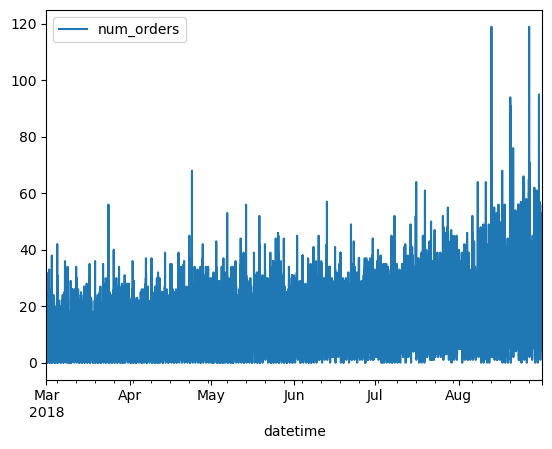

In [5]:
data.plot()

<Axes: xlabel='datetime'>

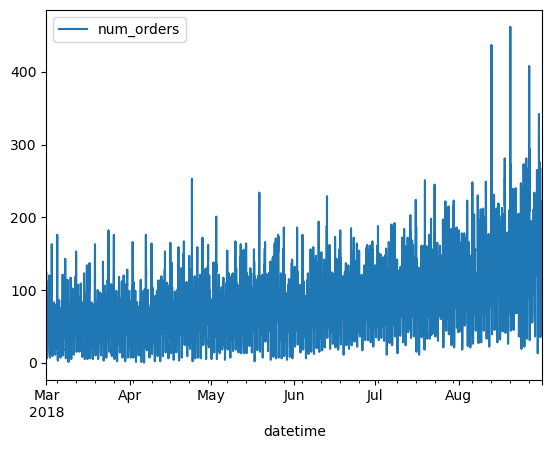

In [6]:
# Remuestreo 
data = data.resample('1H').sum() # Agrupamos con el total de pedidos cada hora 
data.plot()

In [7]:
# Verificamos 
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


¡Tenemos agrupado las ordenes por cada hora!

## Análisis

In [8]:
# Creamos una copia de la data para ser analizada 
data_for_analytics = data.copy()

In [9]:
data_for_analytics

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [10]:
# Analizemos los datos de 10 dias consecutivos en el mes de marzo 
data_days = data_for_analytics['2018-03-01':'2018-03-31'].copy()

In [11]:
data_days

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-03-31 19:00:00,70
2018-03-31 20:00:00,59
2018-03-31 21:00:00,53


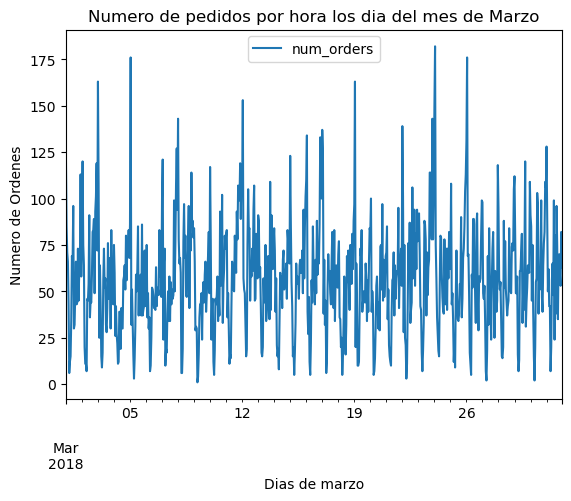

In [12]:
data_days.plot(title = 'Numero de pedidos por hora los dia del mes de Marzo',xlabel = 'Dias de marzo', ylabel= 'Numero de Ordenes')
plt.show()

Aparenta ser una serie temporal estacionaria, veamos la media y la varianza movil. 

In [13]:
# Calculamos la media movil y la varianza movil
data_days['mean'] = data_days['num_orders'].rolling(163).mean()  # Una ventana de  163 horas es decir 1 semana 
data_days['std'] = data_days['num_orders'].rolling(163).std()

<Figure size 2000x600 with 0 Axes>

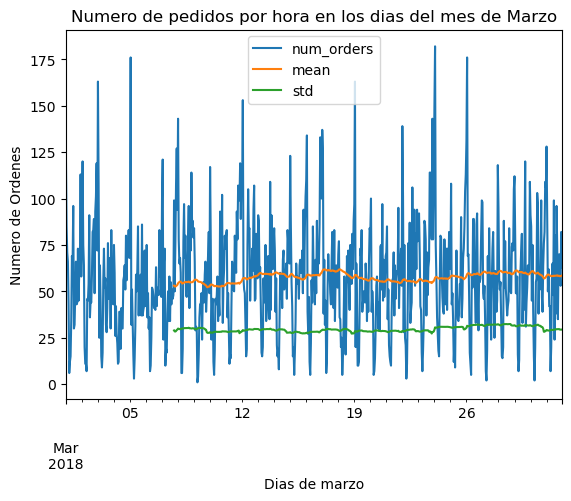

In [14]:
# Cambiar el tamaño de la figura
plt.figure(figsize=(20, 6))  
data_days.plot(title = 'Numero de pedidos por hora en los dias del mes de Marzo',xlabel = 'Dias de marzo', ylabel= 'Numero de Ordenes')
plt.show()

Vemos que la media y varianza movil tienen un comportamiento relativamente estable, casi constantes. Por ejemplo no vemos que estan creciendo o que estan decreciendo de manera drastica. Sabemos que en términos prácticos, una serie estacionaria tiene un comportamiento estadístico "predecible" que no depende del tiempo en que se observa.

**Informacion util que sera usada para la ingeneria de caracteristicas (IMPORTANTE)** 

Al agregar lags de 168 horas (una semana) el modelo mejora significativamente indica que existe un patrón semanal recurrente en tus datos. Esto tiene sentido en muchos contextos, especialmente en series temporales que están influenciadas por ciclos regulares como:

Ciclos de comportamiento humano:

Si los datos reflejan actividades humanas (como tráfico, ventas, consumo energético), es común observar patrones semanales. Por ejemplo, la actividad los fines de semana puede ser muy diferente a la de los días laborales.
**Para nuestro proyecto sabemos que el pedido de taxi puede ir variando dependiendo del dia y la hora** 

Estacionalidad semanal

La estacionalidad semanal es común en series temporales. Al incluir lags de 168 horas, el modelo tiene información directa sobre el comportamiento de la variable objetivo en el mismo momento de la semana anterior, lo cual puede ser altamente predictivo.

Información contextual útil:

Los lags más largos como 168 horas ayudan al modelo a aprender relaciones que ocurren a largo plazo, mientras que lags más cortos (como 1 o 3 horas) capturan fluctuaciones inmediatas. La combinación de ambos enriquece la capacidad del modelo para generalizar mejor.

¿Por qué mejora con lags de 168 horas?

Aumenta la capacidad del modelo para capturar patrones recurrentes:

Si nuestra serie temporal tiene un fuerte componente semanal, el modelo puede beneficiarse al recibir como entrada valores pasados que ocurrieron en el mismo momento del ciclo anterior.

Mayor riqueza de información:

Los lags de 168 horas actúan como un "recordatorio" para el modelo sobre lo que ocurrió una semana antes. Esto es particularmente útil si la serie es altamente correlacionada con su propio historial.
Reducción del ruido:

Los lags largos pueden suavizar el efecto de ruido presente en datos más recientes (como fluctuaciones diarias), permitiendo al modelo centrarse en patrones más estructurados y predecibles.

**Analisis por dias** 

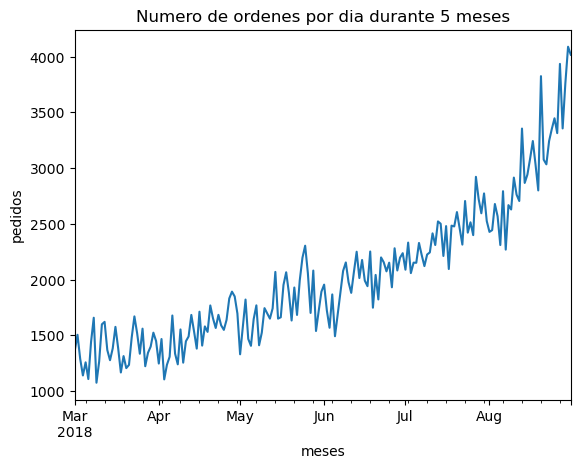

In [15]:
data_for_analytics = data_for_analytics.resample('1D').sum()  # Remuestramos por dia para observar mejor los pedidos 
data_for_analytics['rolling_mean'] =  data_for_analytics.rolling(10).mean() # Calculamos la media movil con una ventana de 10 dias 
data_for_analytics['num_orders'].plot(title = 'Numero de ordenes por dia durante 5 meses', xlabel = 'meses', ylabel = 'pedidos')
plt.show()

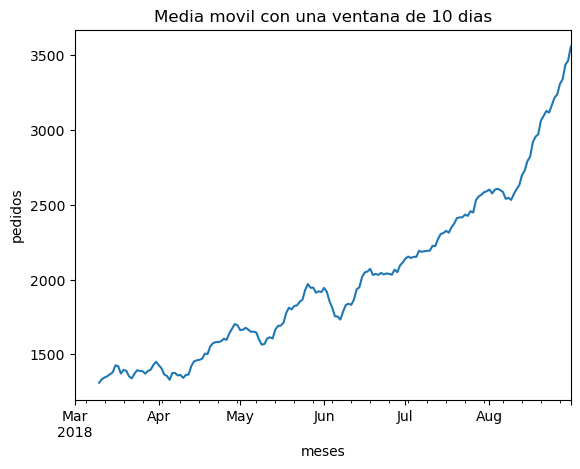

In [16]:
# Suavizamos la grafica 
data_for_analytics['rolling_mean'].plot(title = 'Media movil con una ventana de 10 dias', xlabel = 'meses', ylabel = 'pedidos')
plt.show()

Podemos ver el notorio aumento de pedidos conforme avanza los meses, algunas cuantas caidas un tanto leves. 

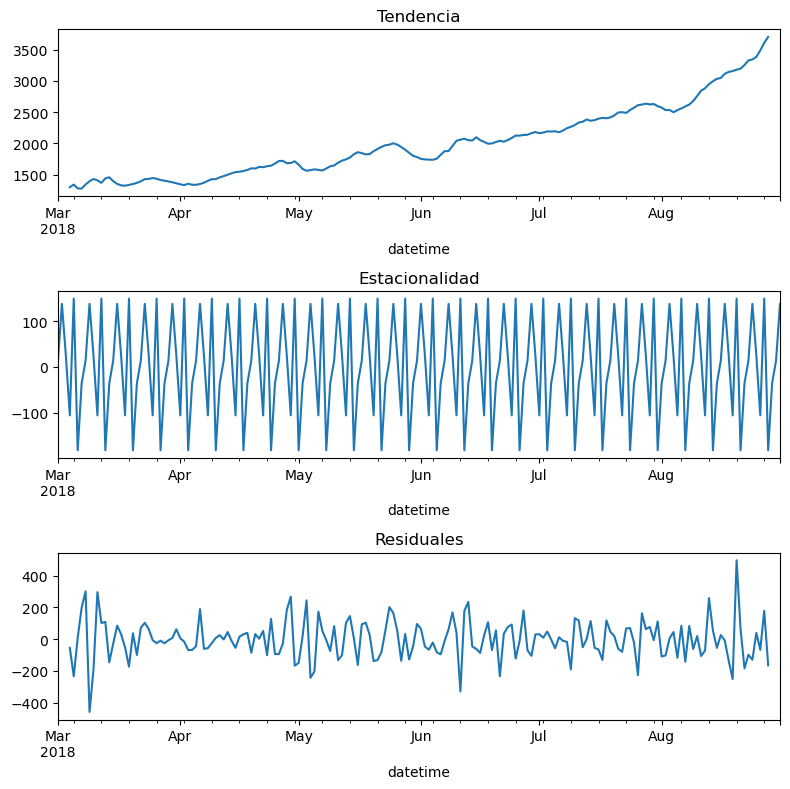

In [17]:
decomposed = seasonal_decompose(data_for_analytics['num_orders'])

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()    # esto ayuda a encajar gráficos secundarios en el área

1. Tendencia (Trend)
 - Recordar: Representa los cambios a largo plazo en los datos, eliminando fluctuaciones estacionales y aleatorias.
 - En este caso, se observa un crecimiento constante en el número de pedidos desde marzo hasta agosto de 2018. Esto podría indicar un aumento continuo de la actividad o popularidad del servicioo de taxi en los aeropuertos. 
 
2. Estacionalidad (Seasonal)
  - Recordar: Muestra los patrones repetitivos que ocurren en intervalos regulares
  - El patrón parece ser bastante periódico, lo que podría indicar fluctuaciones en función de los días laborales y fines de semana. 

Días laborales: Mayor actividad.

Fines de semana: Posible descenso.

Analizar este patrón puede ser útil para prever la demanda en días específicos y planificar recursos (como aumentar taxista en cierto dia) Vemos una aplitud de 300 (+150 - 150 aprox), lo cual es una cantidad de pedidos considerable como para designar más demanda de personal.
 

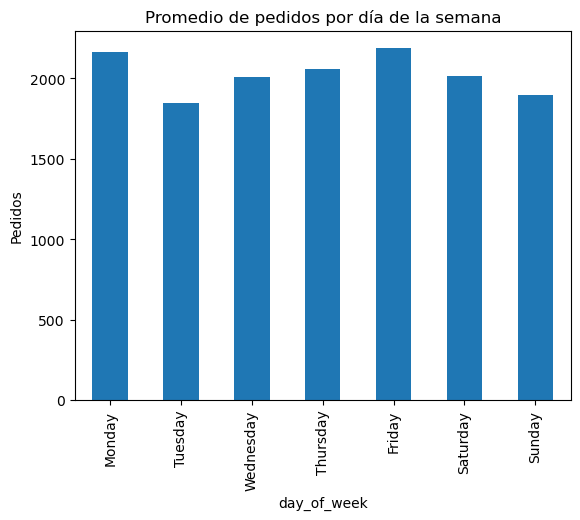

In [18]:
# Agregar el día de la semana como una nueva columna
data_for_analytics['day_of_week'] = data_for_analytics.index.day_name()

# Calcular el promedio de pedidos por cada día de la semana
avg_by_day = data_for_analytics.groupby('day_of_week')['num_orders'].mean()

# Ordenar los días de la semana para que aparezcan en el orden correcto
avg_by_day = avg_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Graficar el promedio de pedidos por día de la semana
avg_by_day.plot(kind='bar', title='Promedio de pedidos por día de la semana', ylabel='Pedidos')
plt.show()


El patron es mostrar picos los lunes luego una bajada en los los martes y a mitad de semana un pico, por lo que los fines de semana hay una bajada en los pedidos como se mencionó en la grafica de estacionalidad.

La gráfica de barras refleja los promedios absolutos, y confirma que los fines de semana tienen menos pedidos, pero no hay una caída dramática.

Es importante decir que la descomposición estacional enfatiza patrones cíclicos relativos para resaltar tendencias que podrían ser útiles en análisis de series temporales (en este proyecto asignar mayor personal los dias o horas con más demanda).

## Prueba de cordura

In [19]:
# Prueba de cordura 
train, test = train_test_split(data, shuffle = False, test_size = 0.20)
predict_mediana = np.ones(test.shape[0]) * train['num_orders'].median()
ECM = mean_squared_error(test,predict_mediana)
print('Raiz del error cuadratico medio (RECM): ',ECM ** 0.5)

Raiz del error cuadratico medio (RECM):  76.00579729020318


Vemos que no superamos el umbral del proyecto (48), probemos ahora con lo siguiente: 
 
El nuevo valor x(t) se predice mediante el valor anterior de la serie, definido como x(t-1). Este método es independiente de la métrica. Considera que el último valor de los datos de entrenamiento se puede utilizar como el primer valor de los datos de prueba.

In [20]:
predict  = test.shift()
predict.iloc[0] = train['num_orders'].iloc[-1]
ECM = mean_squared_error(test,predict)
print('Raiz del error cuadratico medio (RECM): ',ECM ** 0.5)

Raiz del error cuadratico medio (RECM):  53.36807644753937


¡ Interesante ! logramos bajar el error a 53 aprox el numero de pedidos.Interpretamos esto de la siguiente manera: si deseamos predecir el numero de pedidos durante la siguiente podemos predecirla como el valor de pedidos de la anterior hora. **Claro, con un error de 53 pedidos en promedio.**

Tenemos este umbral y el umbral de nuestro proyecto que tiene que ser menor a 48, ahora asi aplicaremos un modelo ML para poder predecir la cantidad de pedidos

## Análisis y Ajustes Iniciales

En el proceso de modelado, inicialmente experimenté con diferentes valores para los lags de las características, partiendo del supuesto de que un lag de 24 horas podría ser suficiente para capturar patrones diarios relevantes en los datos. Esto se basó en que el objetivo era predecir la cantidad de pedidos para la siguiente hora. Sin embargo, este enfoque inicial resultó en modelos que no pasaban la prueba de cordura, indicando que la información proporcionada por los lags no era suficiente para representar la dinámica temporal del sistema.

Posteriormente, me enfoqué en ajustar los hiperparámetros del modelo para mejorar su capacidad de generalización. A pesar de estos esfuerzos, los modelos continuaban sobreajustándose, generando errores considerablemente bajos en el conjunto de entrenamiento, pero resultados insatisfactorios en el conjunto de prueba. Esto reforzó la necesidad de revisar la selección de características y capturar mejor las relaciones temporales subyacentes.

**Ajuste de Lags para Capturar Patrones Semanales**

Se exploraron diferentes configuraciones de lags y se identificó que incluir un mayor rango temporal, específicamente lags de hasta 168 horas (una semana), permitía a los modelos capturar patrones semanales importantes que no estaban representados con ventanas más cortas. Esto mejoró significativamente la capacidad de generalización del modelo.

Finalmente, se decidió utilizar la siguiente configuración de lags:

Lags individuales: lag_1, lag_12, lag_24, lag_36, ..., lag_168
Esto permite capturar no solo patrones diarios, sino también tendencias más amplias dentro de la semana. Además, esta configuración asegura que los modelos tengan acceso a un rango más diversificado de información temporal.

**Impacto de la Media y Varianza Móvil**

Paralelamente, se analizaron características derivadas, como la media y varianza móvil, para complementar los lags. Se observó que:

Ventanas pequeñas: Una ventana de tamaño reducido (e.g., 6 horas) mejoró la calidad del modelo. Esto sugiere que capturar las fluctuaciones a corto plazo aporta información adicional que los lags por sí solos no representan.

Ventanas largas: En contraste, una ventana semanal (168 horas) para la media y varianza móvil no mostró beneficios y, en algunos casos, empeoró los resultados del modelo. Esto puede deberse a la redundancia de esta información con los lags ya incluidos, lo que podría introducir ruido y afectar negativamente el desempeño.


**Conclusión y Siguiente Paso**

Con base en estos hallazgos, se definió una estrategia de ingeniería de características enfocada en maximizar la información útil para el modelo y minimizar redundancias. El conjunto final incluye:

Lags representativos: Para capturar tanto patrones a corto plazo como semanales.
Media y varianza móvil: Limitadas a ventanas pequeñas (e.g., 6 horas), ya que ventanas más amplias no agregaron valor adicional.
El siguiente paso será profundizar en la creación de características derivadas más complejas, como tendencias móviles o diferencias entre medias a corto y largo plazo, para mejorar aún más la capacidad predictiva del modelo.

Ahora, procedamos a detallar la implementación de la ingeniería de características.

In [21]:
# Creacion de caracteristicas
def make_features(data,rolling_mean_size,rolling_std): 
    
    # Crear características temporales
    data['month'] = data.index.month  # mes
    data['day'] = data.index.day     #dia del mes 
    data['dayofweek'] = data.index.dayofweek    # dia de la semana 
    data['hour'] = data.index.hour    # hora del dia 
    
    # Crear características de lag
    for lag in range(15):
        if(lag ==  0):
            data['lag_1'] = data['num_orders'].shift(1)
        else:
            lag = (lag) * 12
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
            
    # Crear características de medias móviles y desviaciones estándar
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()  # Excluimos el valor x(t) para evitar el data leakage
    data['rolling_std'] = data['num_orders'].shift(1).rolling(rolling_std).std()


In [22]:
# Ingeneria de caracteristicas 
make_features(data,6,6)

In [23]:
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_12,lag_24,lag_36,lag_48,...,lag_84,lag_96,lag_108,lag_120,lag_132,lag_144,lag_156,lag_168,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,46.0,72.0,39.0,169.0,...,71.0,152.0,37.0,126.0,50.0,123.0,22.0,113.0,172.666667,41.389210
2018-08-31 20:00:00,154,8,31,4,20,136.0,182.0,142.0,166.0,191.0,...,159.0,96.0,131.0,122.0,124.0,105.0,108.0,179.0,167.666667,44.080230
2018-08-31 21:00:00,159,8,31,4,21,154.0,203.0,198.0,226.0,170.0,...,195.0,152.0,174.0,107.0,147.0,162.0,196.0,166.0,171.166667,41.537533


In [24]:
# Eliminamos los valores nulos 
data = data.dropna()
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_12,lag_24,lag_36,lag_48,...,lag_84,lag_96,lag_108,lag_120,lag_132,lag_144,lag_156,lag_168,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,34.0,100.0,41.0,42.0,...,30.0,75.0,32.0,163.0,36.0,90.0,30.0,124.0,92.333333,26.658332
2018-03-08 01:00:00,78,3,8,3,1,143.0,55.0,121.0,42.0,75.0,...,30.0,60.0,28.0,108.0,45.0,120.0,32.0,85.0,99.666667,33.921478
2018-03-08 02:00:00,65,3,8,3,2,78.0,43.0,24.0,40.0,36.0,...,56.0,26.0,41.0,25.0,44.0,75.0,48.0,71.0,104.333333,26.927062
2018-03-08 03:00:00,68,3,8,3,3,65.0,51.0,66.0,63.0,49.0,...,58.0,42.0,76.0,64.0,59.0,64.0,66.0,66.0,102.500000,29.494067
2018-03-08 04:00:00,60,3,8,3,4,68.0,46.0,73.0,42.0,30.0,...,64.0,27.0,46.0,44.0,82.0,20.0,43.0,43.0,95.833333,32.381579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,46.0,72.0,39.0,169.0,...,71.0,152.0,37.0,126.0,50.0,123.0,22.0,113.0,172.666667,41.389210
2018-08-31 20:00:00,154,8,31,4,20,136.0,182.0,142.0,166.0,191.0,...,159.0,96.0,131.0,122.0,124.0,105.0,108.0,179.0,167.666667,44.080230
2018-08-31 21:00:00,159,8,31,4,21,154.0,203.0,198.0,226.0,170.0,...,195.0,152.0,174.0,107.0,147.0,162.0,196.0,166.0,171.166667,41.537533


**Recordemos** 

- Entrenamiento: Para ajustar el modelo.
- Validación: Para ajustar hiperparámetros y prevenir sobreajuste.
- Prueba (test): Para evaluar el desempeño final del modelo con datos que el modelo no ha visto durante el entrenamiento o la validación.

Para nuestros datos aplicaremos una proporcion de 70:20:10, como se pide para el proyecto (10 % para test) dado que el orden temporal debe preservarse, la división debe realizarse respetando la cronología de los datos.

In [25]:
# Separamos las caracteristicas del objetivo 
features = data.drop('num_orders',axis = 1)
target = data['num_orders']

In [26]:
# Paso 1: Dividir en entrenamiento (70%) y el resto (30%)
features_train,X_temp,target_train, Y_temp = train_test_split(features,target, test_size=0.3, shuffle=False)
# Paso 2: Dividir el resto en validación (20%) y prueba (10%)
features_val,features_test,target_val,target_test = train_test_split(X_temp,Y_temp,test_size=0.5, shuffle=False)

**Bosque aleatorio de regresion**

In [27]:
%%time
best_error = float('inf')  # Inicializa con un valor de error muy alto
best_depth = None  # Inicializa para llevar un seguimiento de la mejor profundidad

for depth in range(1, 20): 
    model = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=54321)  
    model.fit(features_train, target_train)
    predictions = model.predict(features_val)
    error = mean_squared_error(target_val, predictions) ** 0.5  # Calcular RMSE
    if error < best_error: 
        best_depth = depth
        best_error = error

print(f"Mejor profundidad: {best_depth} con RMSE: {best_error}")

Mejor profundidad: 13 con RMSE: 25.152503648227675
CPU times: user 29 s, sys: 26.8 ms, total: 29 s
Wall time: 29 s


In [28]:
# Ahora solo seleccionamos el mejor modelo con los mejores hiperparametros. 
model = RandomForestRegressor(n_estimators=100, max_depth=best_depth, random_state=54321)  
model.fit(features_train, target_train)

RandomForestRegressor(max_depth=13, random_state=54321)

In [29]:
predictions_test = model.predict(features_test) #predicciones test
error_test = mean_squared_error(target_test, predictions_test) ** 0.5
predictions_val = model.predict(features_val) #predicciones para validacion
error_val = mean_squared_error(target_val, predictions_val) ** 0.5
predictions_train = model.predict(features_train) # predicciones del entrenamiento
error_train = mean_squared_error(target_train, predictions_train) ** 0.5
print("RMSE con el los datos de entrenamiento: ", error_train)
print("RMSE con la validacion: ", error_val)
print("RMSE con el los datos de prueba: ", error_test)

RMSE con el los datos de entrenamiento:  8.661022739455213
RMSE con la validacion:  25.152503648227675
RMSE con el los datos de prueba:  42.06035785003883


Para el modelo de Bosque Aleatorio de Regresión, el error obtenido fue de 42 pedidos. Este valor indica que el modelo es capaz de predecir la cantidad de pedidos de taxis en el aeropuerto para la siguiente hora con una desviación media de 42 pedidos. Este desempeño refleja una mejora significativa en la capacidad del modelo para generalizar y hacer predicciones precisas, dado que ha logrado reducir el margen de error respecto al umbral definido inicialmente.

**Gradient boosting**

In [30]:
import lightgbm as lgb

In [31]:
model = lgb.LGBMRegressor(
    n_estimators=1000,       # Número de árboles
    num_leaves=31,           # Número de hojas
    max_depth=7,             # Profundidad máxima de los árboles
    learning_rate=0.1,       # Tasa de aprendizaje
    metric='rmse'            # Métrica para evaluación
)

model.fit(
    features_train, target_train,
    eval_set=[(features_val, target_val)],
    early_stopping_rounds=50,  # Detener si no hay mejora durante 50 rondas
    verbose=10
)


[10]	valid_0's rmse: 30.8283
[20]	valid_0's rmse: 26.1961
[30]	valid_0's rmse: 25.3235
[40]	valid_0's rmse: 25.2416
[50]	valid_0's rmse: 25.3453
[60]	valid_0's rmse: 25.3386
[70]	valid_0's rmse: 25.3357
[80]	valid_0's rmse: 25.3118
[90]	valid_0's rmse: 25.3322


/home/lautaro/yes/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/lautaro/yes/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(max_depth=7, metric='rmse', n_estimators=1000)

In [32]:
predictions_test = model.predict(features_test) #predicciones test
error_test = mean_squared_error(target_test, predictions_test) ** 0.5
predictions_val = model.predict(features_val) #predicciones para validacion
error_val = mean_squared_error(target_val, predictions_val) ** 0.5
predictions_train = model.predict(features_train) # predicciones del entrenamiento
error_train = mean_squared_error(target_train, predictions_train) ** 0.5
print("RMSE con el los datos de entrenamiento: ", error_train)
print("RMSE con la validacion: ", error_val)
print("RMSE con el los datos de prueba: ", error_test)

RMSE con el los datos de entrenamiento:  13.900209669437956
RMSE con la validacion:  25.217581376292028
RMSE con el los datos de prueba:  43.32343088533709


Al comparar los resultados obtenidos con Gradient Boosting de LightGBM, el modelo muestra un error de 43.32 pedidos, lo cual está muy cerca del error logrado con el modelo de Bosque Aleatorio de Regresión (42 pedidos). Esta ligera diferencia en el error indica que el modelo LightGBM es competitivo en términos de precisión, lo que sugiere que ambos enfoques (Bosque Aleatorio y Gradient Boosting) tienen un rendimiento similar en cuanto a la predicción de la demanda de taxis en el aeropuerto.

Una de las ventajas clave de LightGBM es su mayor rapidez en la respuesta. El algoritmo de Gradient Boosting de LightGBM es conocido por ser altamente eficiente en términos de tiempo de entrenamiento y predicción

## Conclusiones

En este proyecto, se buscó predecir la cantidad de pedidos de taxis en el aeropuerto para la siguiente hora utilizando modelos de regresión. A través de una cuidadosa ingeniería de características, se probaron diferentes valores de lags y ventanas para medias y varianzas móviles. Al incorporar lags semanales (hasta 168 horas) y ajustar las ventanas móviles a 24 horas para patrones diarios, el modelo mostró mejoras significativas en su capacidad de generalización.

Se evaluaron dos enfoques: Bosque Aleatorio de Regresión y Gradient Boosting con LightGBM. Ambos modelos alcanzaron errores de predicción cercanos a los 42 pedidos, con LightGBM destacándose por su rapidez en la respuesta. Finalmente, el modelo más eficiente en términos de tiempo y precisión es LightGBM, lo que lo convierte en la opción preferida para este caso de predicción en tiempo real.

Este proyecto demuestra cómo la combinación de una ingeniería de características adecuada, el ajuste de hiperparámetros y la elección del modelo correcto puede generar soluciones precisas y eficientes para problemas de predicción en series temporales.